## Load and Clean Data

1. Both TE and gene data generated by UROMOL group is loaded into a pandas dataframe
2. Samples are ordered by there UROMOL ID ('U0001' -> 'U2122')
3. All simple repeat elements are eliminated
4. Elements with no expression in any sample were also removed

In [1]:
import pandas as pd
from Funcs.ReorderUROMOL import UROMOLreorder

# load in both Gene and TE transcriptomic expression
Gene = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-Gene-RAW.csv', index_col='Unnamed: 0')
TE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-TE-RAW.csv', index_col='Unnamed: 0')
RepName = pd.read_csv('~/Desktop/UROMOL-TE/TE-RepName.csv', index_col= 'Unnamed: 0', usecols=[0, 3])
IntronTE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-INTRONTE-RAW.csv', index_col='Unnamed: 0')

# order the dataframe by UROMOL ID
IDs = []
for sample in TE.columns.tolist():
    IDs.append(int(sample.split('U')[1]))

TE = UROMOLreorder(IDs, TE)
IntronTE = UROMOLreorder(IDs, IntronTE)
Gene = UROMOLreorder(IDs, Gene)

# eliminate all simple repeat and unwanted elements from the TE dataset
TransposableClasses = ['LINE', 'SINE', 'LTR', 'DNA', 'Retroposon']
TENames = RepName[RepName['repClass'].isin(TransposableClasses)].index.values.tolist()
TE = TE.loc[TENames, :]

# There are two TEs that are not captured in the intronic data
TENames.remove('HERV-Fc2-int')
TENames.remove('MLT1M-int')
IntronTE = IntronTE.loc[TENames, :]

# remove all TE and Gene elements with no expression
TE = TE.loc[~(TE==0).all(axis=1)]
Gene = Gene.loc[~(Gene==0).all(axis=1)]
IntronTE = IntronTE.loc[~(IntronTE==0).all(axis=1)]

## Percentage of TEs in RNA-seq Data

Although a substantial fraction of the genetic material, transposable elements are transcribed in low numbers. As such, we should ensure that RNA-seq samples contain only a small fraction of TE mapped reads

1. Sum TE and Gene expression
2. Calculate the percentage of transcripts mapping to TEs
3. Generate a stackplot, with a mean line

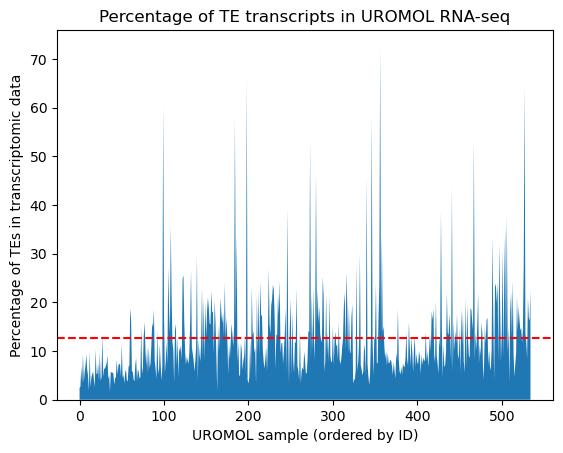

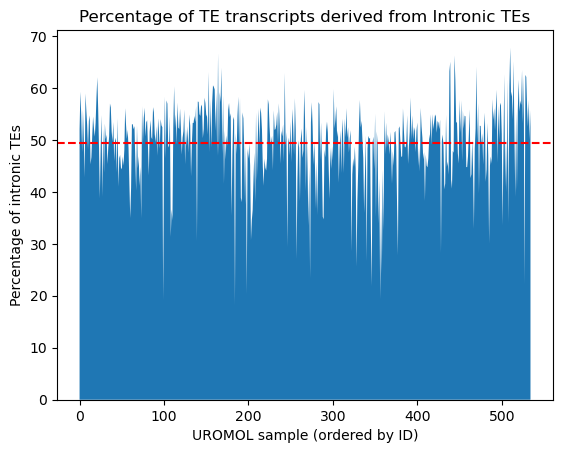

In [2]:
import matplotlib.pyplot as plt

# sum TE expression by sample
INTRONsum = IntronTE.sum(axis='rows')
TEsum = TE.sum(axis='rows')
Genesum = Gene.sum(axis='rows')

# compute the total mapped transcripts
TotalRNA = TEsum + Genesum

# compute the percentage of TE mappings of all transcripts
TEpercent = (TEsum / TotalRNA) * 100
TEpercentmean = TEpercent.mean()

# compute the percentage of intronic TEs
INTRONpercent = (INTRONsum / TEsum) * 100
INTRONpercentmean = INTRONpercent.mean()

# stackplot of percentage of TEs in transcriptomic data
plt.stackplot(range(TEsum.shape[0]), TEpercent)
plt.axhline(TEpercentmean, linestyle='--', c='r')
plt.xlabel('UROMOL sample (ordered by ID)')
plt.ylabel('Percentage of TEs in transcriptomic data')
plt.title('Percentage of TE transcripts in UROMOL RNA-seq')
plt.show()

# stackplot of percentage of intronic reads in transcriptomic data
plt.stackplot(range(TEsum.shape[0]), INTRONpercent)
plt.axhline(INTRONpercentmean, linestyle='--', c='r')
plt.xlabel('UROMOL sample (ordered by ID)')
plt.ylabel('Percentage of intronic TEs')
plt.title('Percentage of TE transcripts derived from Intronic TEs')
plt.show()

# Outlier Detection

## Data Distribution - Histogram

<AxesSubplot:ylabel='Frequency'>

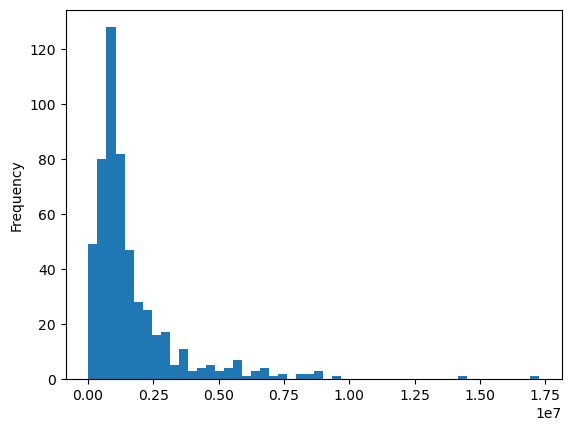

In [9]:
TE.sum(axis='rows').plot.hist(bins=50)

## Batch Effect Evaluation

1. Both clean TE and Gene datasets were zero centered and log2 transformed
2. Boxplot are generated for both normalized dataframes

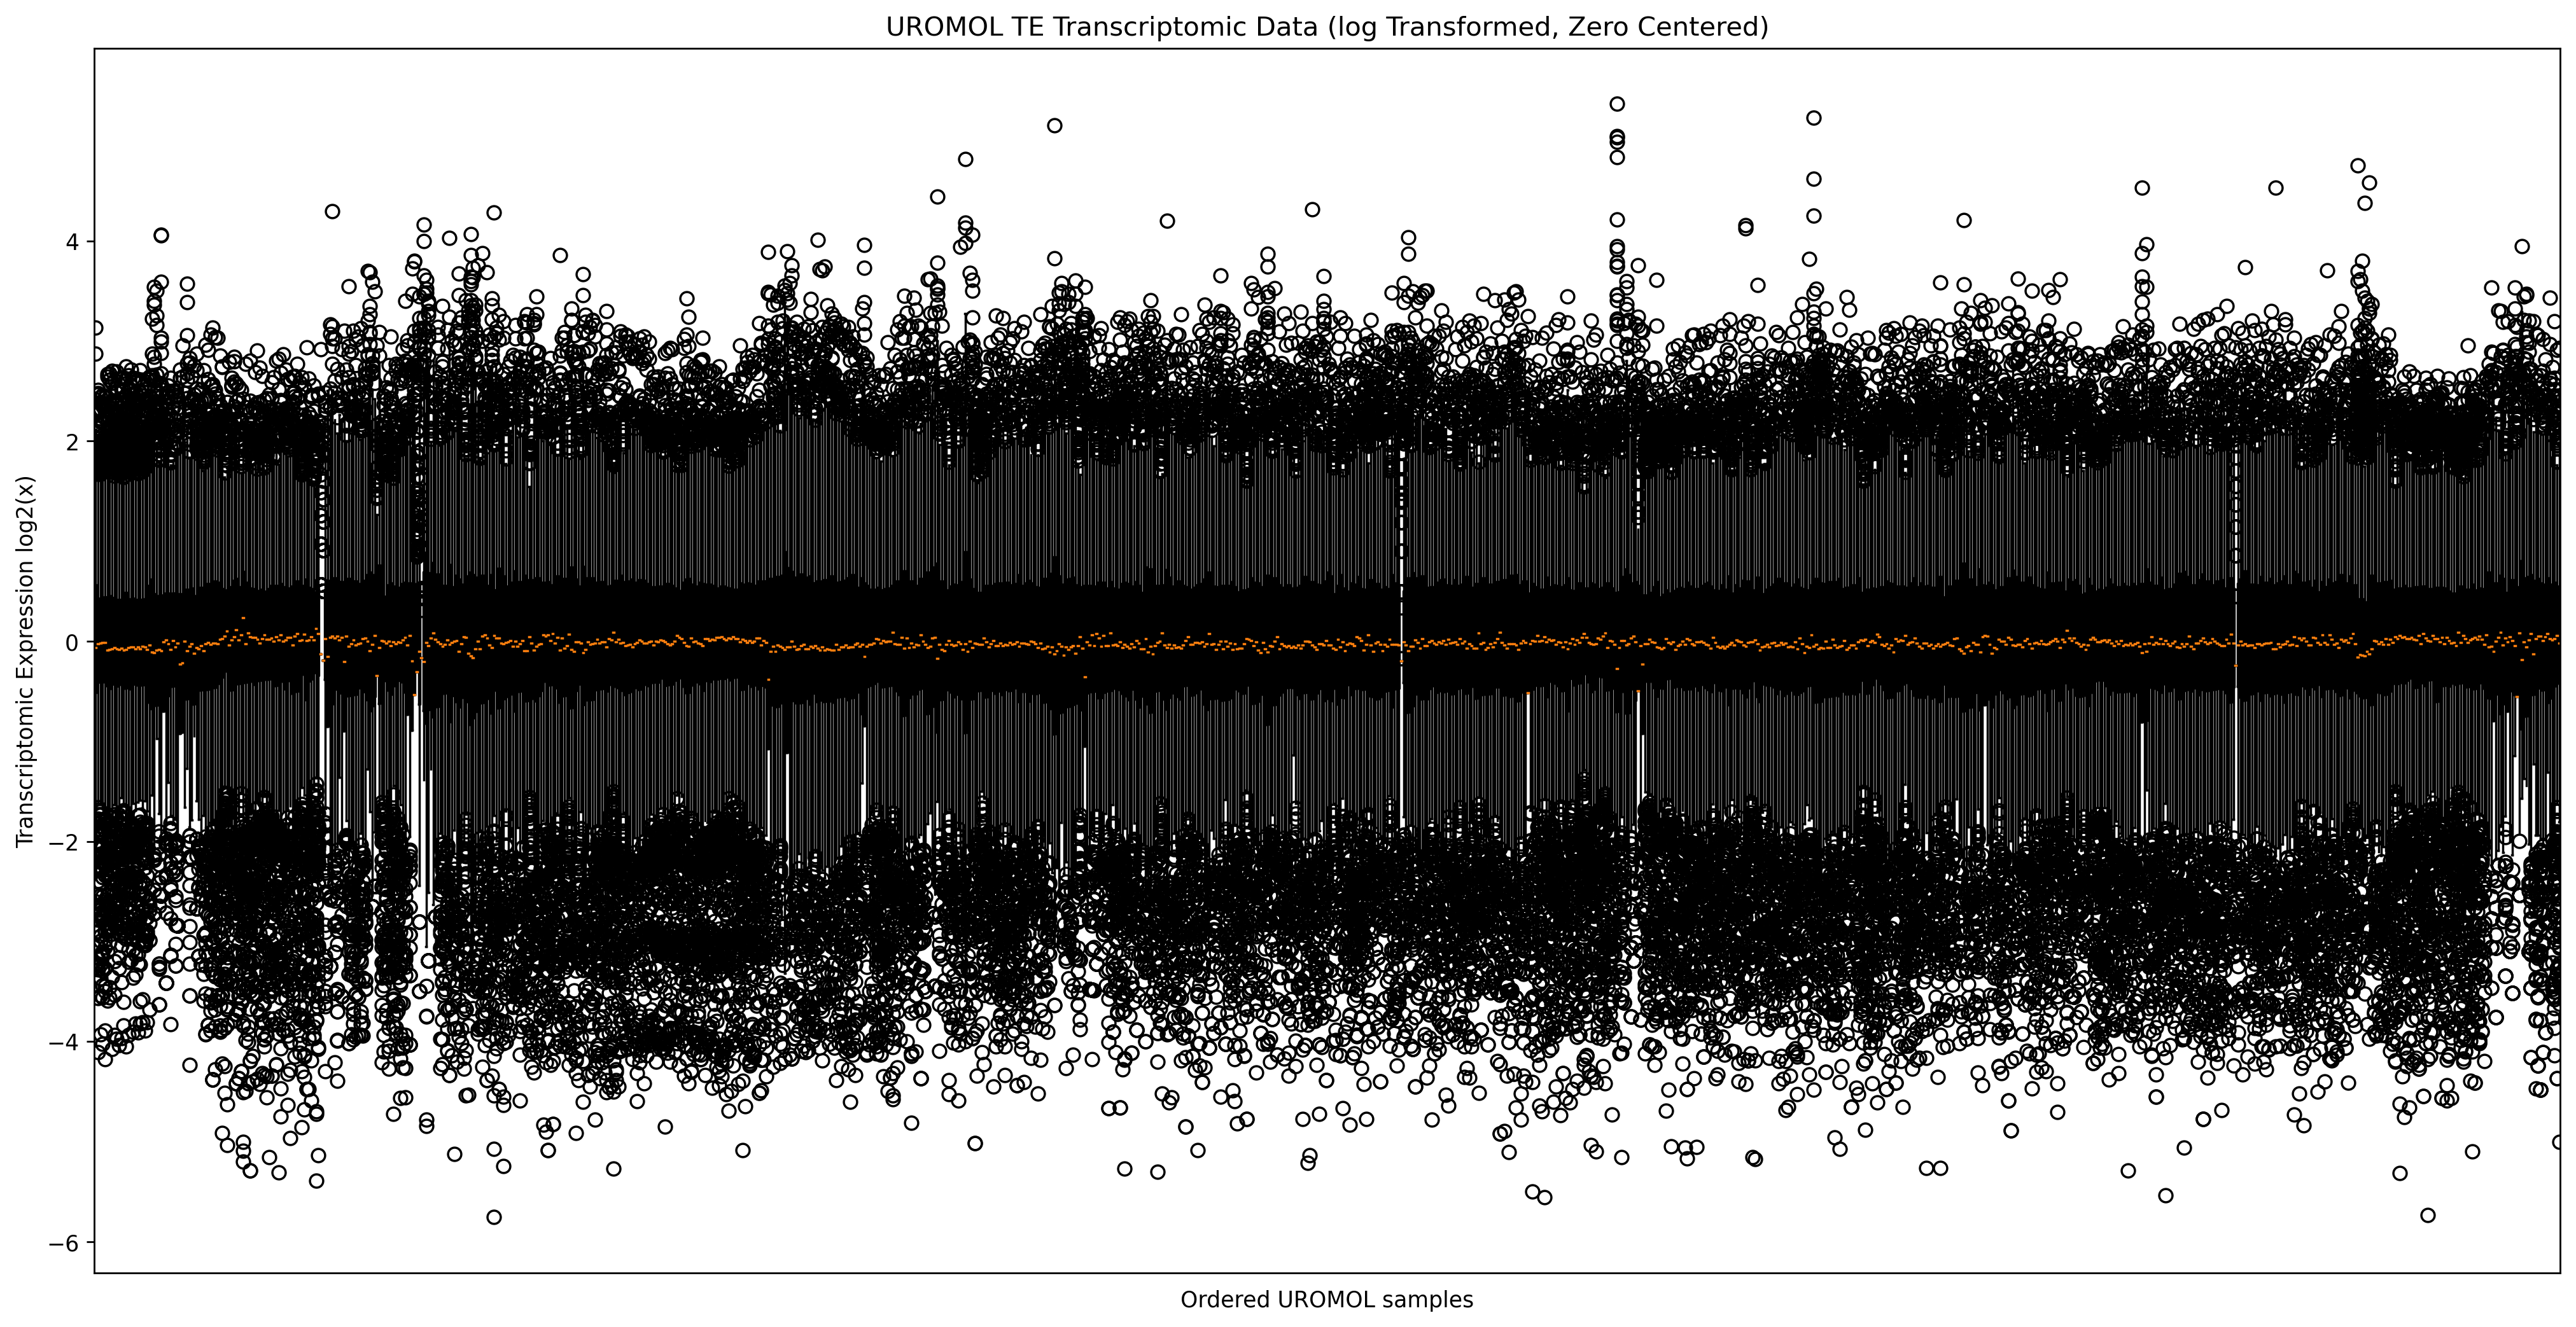

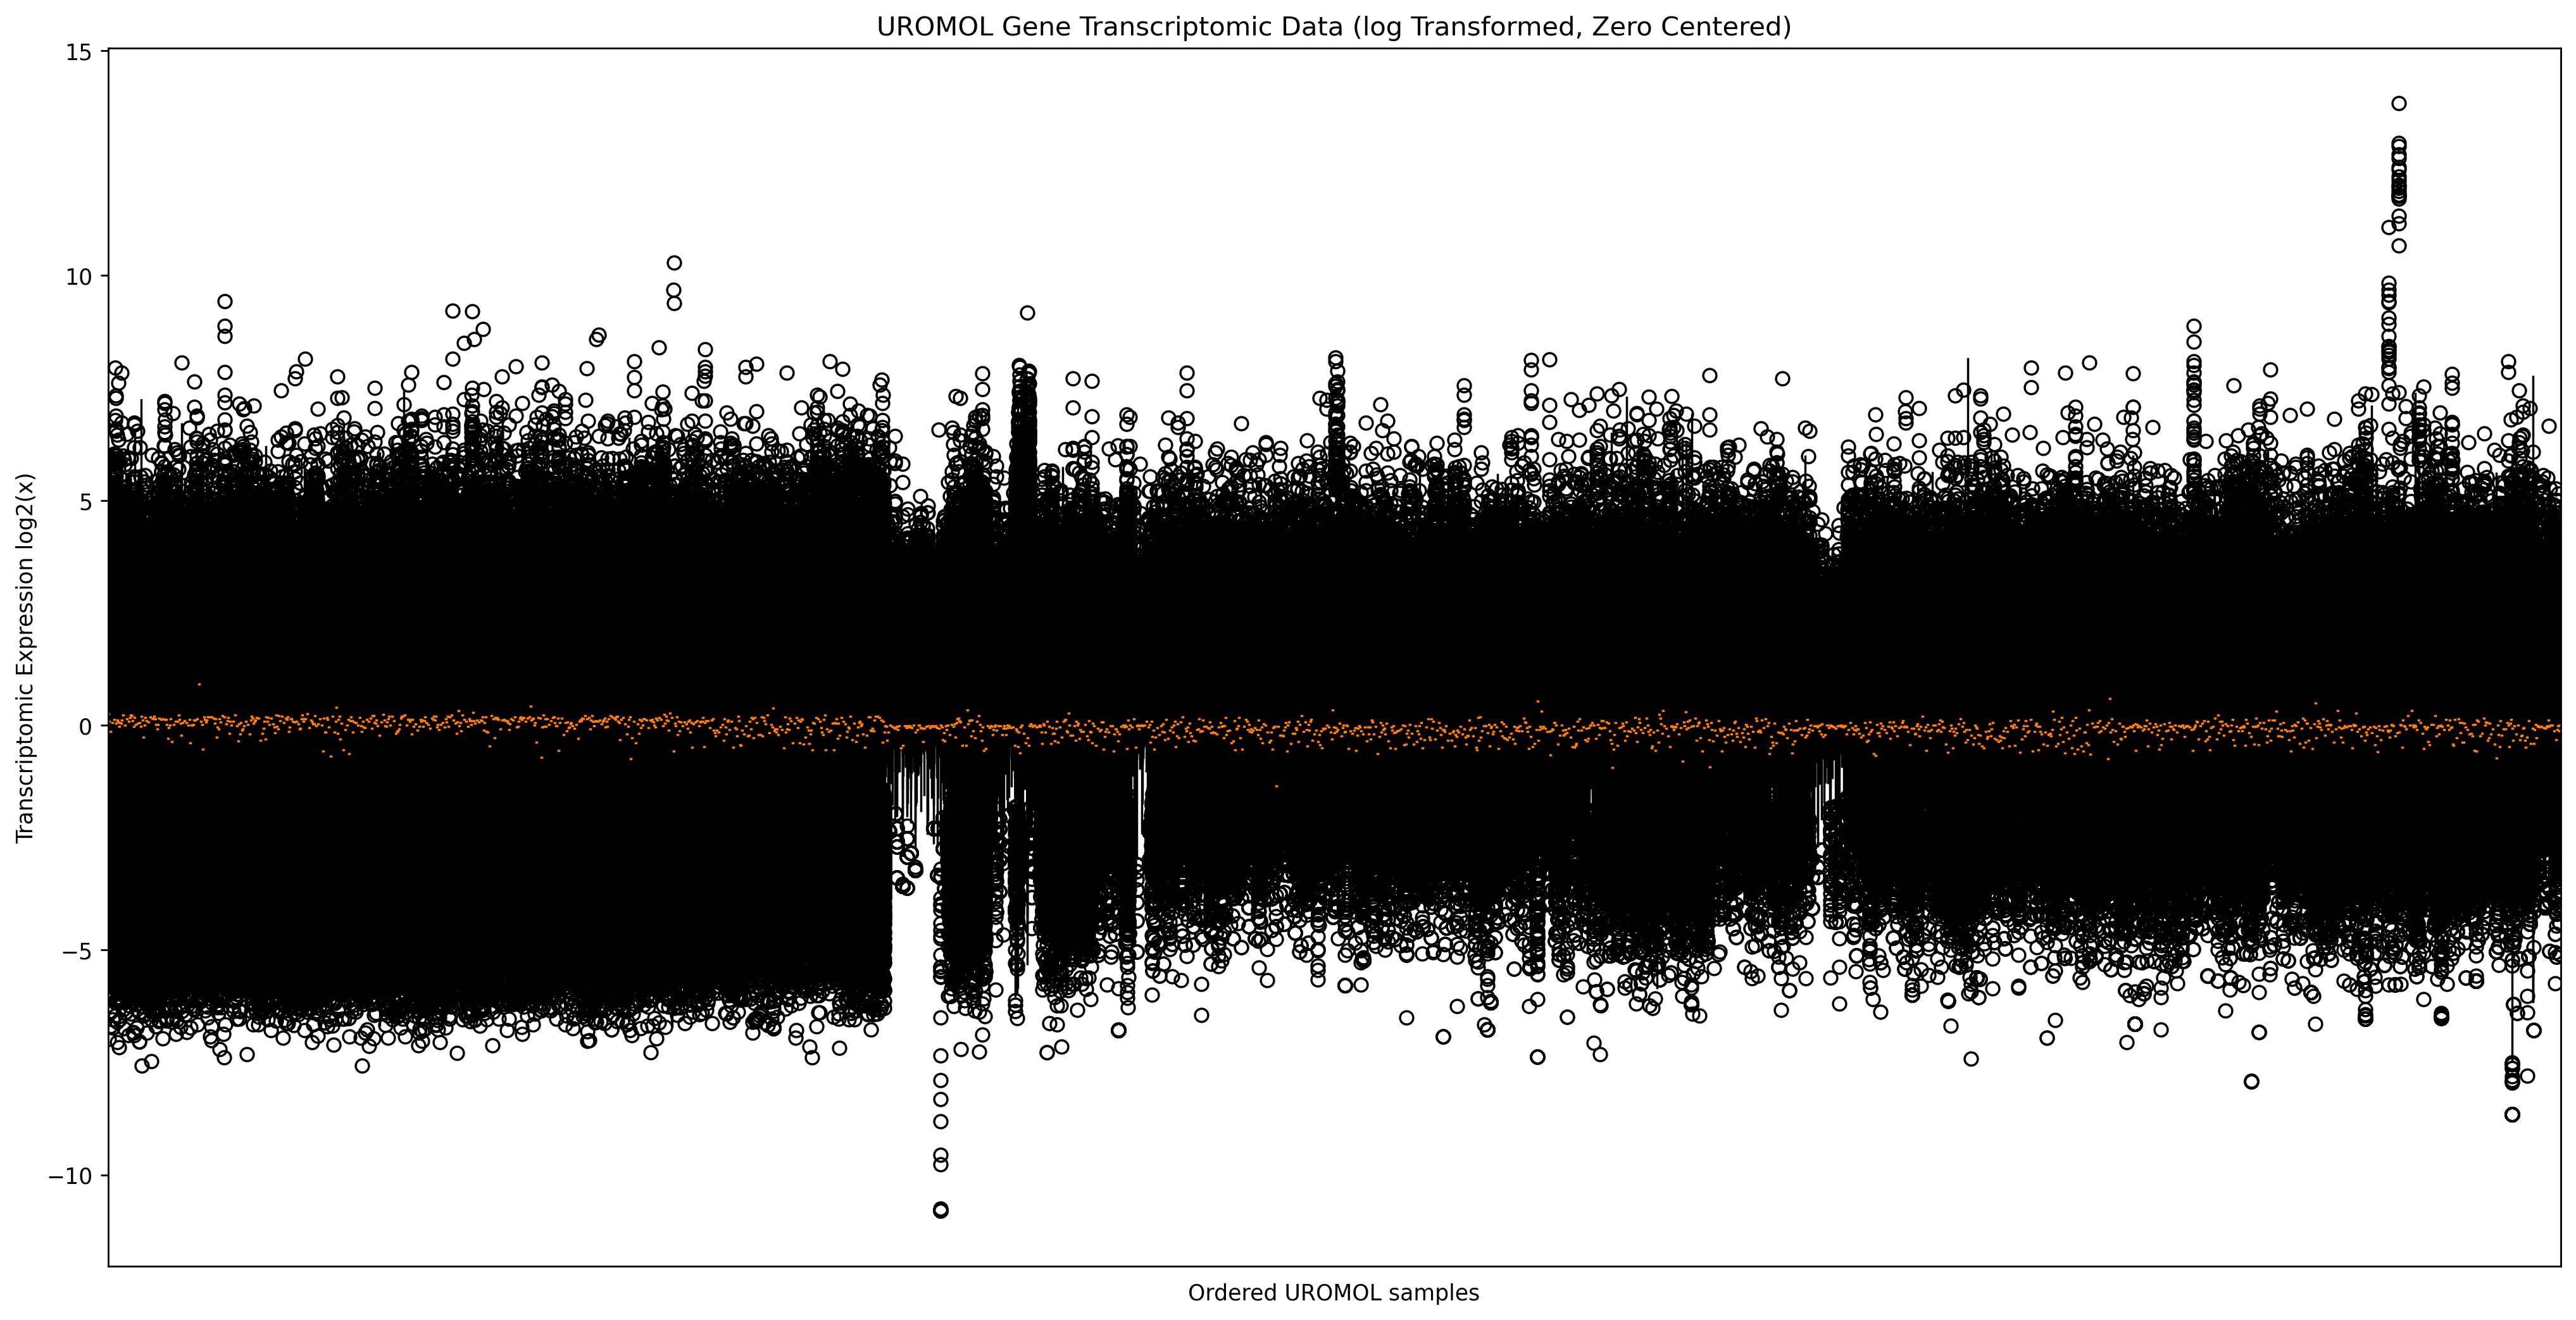

In [4]:
from Funcs.Boxplot import GenerateBoxplot

GenerateBoxplot(TE, 'TE', 'UROMOL-TEBoxplot.png')
GenerateBoxplot(Gene, 'Gene', 'UROMOL-GeneBoxplot.png')

## Interquartile Range Outlier Detection

1. Evaluated the IQR of each sample
2. outiers outlined based on n>300 (k = 1.5) and returned in function
    - David C. Hoaglin & Boris Iglewicz (1987) Fine-Tuning Some Resistant Rules for Outlier Labeling, Journal of the American Statistical Association, 82:400, 1147-1149, DOI: 10.1080/01621459.1987.10478551

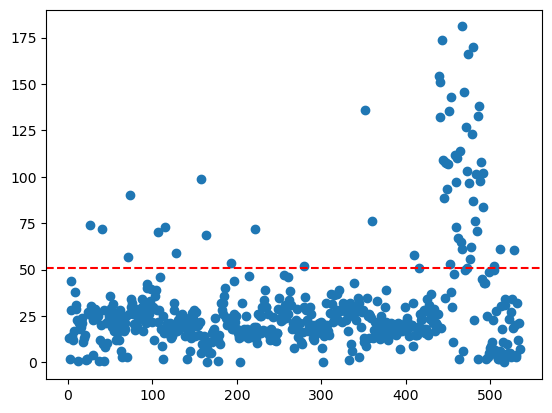

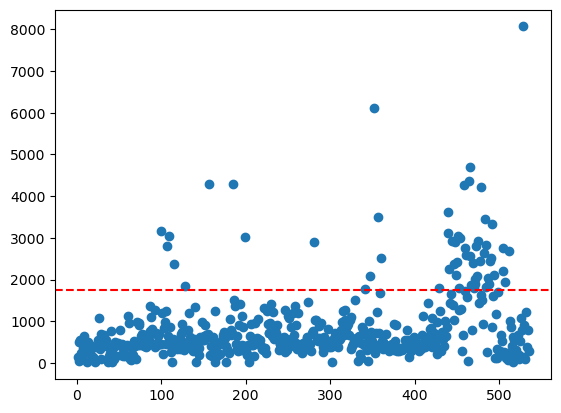

                 0
U0183  3171.636049
U0200  2797.426387
U0204  3044.710967
U0262  2378.138351
U0329  1841.493731
U0434  4301.444934
U0516  4294.667990
U0556  3025.694362
U0965  2905.878666
U1192  1776.971559
U1209  2085.927153
U1232  6112.076385
U1242  3494.153499
U1248  2509.254853
U1432  1789.298580
U2026  3626.007458
U2027  3121.118565
U2028  2254.568239
U2031  2926.916283
U2034  2371.872767
U2035  2903.298927
U2036  2120.967470
U2037  2433.500706
U2038  3054.077983
U2040  1788.553744
U2041  2992.977173
U2045  4270.738746
U2047  2768.140085
U2048  2585.193279
U2051  4356.094133
U2052  2563.252306
U2053  4703.726017
U2054  1863.136793
U2056  2392.362999
U2057  1790.180355
U2058  2008.685152
U2059  1882.529659
U2060  2812.782044
U2061  2086.093702
U2062  2914.717633
U2064  2433.894210
U2065  4221.536148
U2069  2636.856515
U2070  3445.208440
U2071  2831.555991
U2072  1812.607632
U2074  2049.181407
U2075  1898.329253
U2076  2443.307203
U2077  2527.612955
U2078  3329.718229
U2081  2101.

In [14]:
from Funcs.PlotIQR import plotiqr

Geneoutliers = plotiqr(Gene)
TEoutliers = plotiqr(TE)

## Spearman Correlation

how similar are data samples to each other?


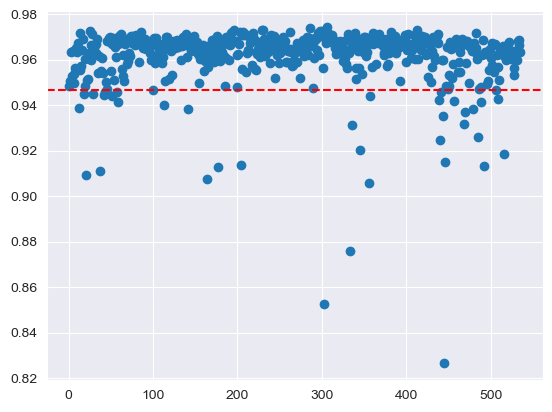

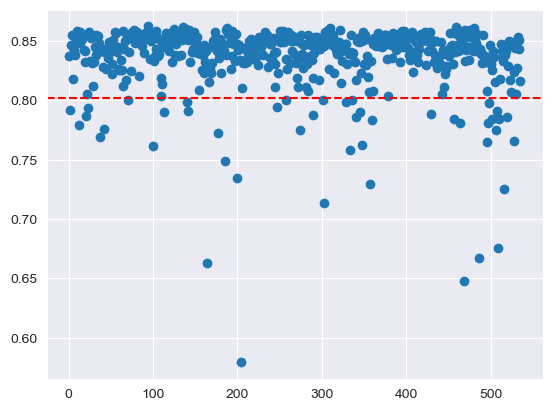

In [3]:
import seaborn as sns
from Funcs.PlotSpearman import plotSpearman

TEspearman = TE.corr(method='spearman')
TEspearmanmean = TEspearman.mean(axis='rows')
plotSpearman(TEspearmanmean)

#sns.heatmap(TEspearman, annot = True)
#plt.savefig('~/Desktop/UROMOL-TE/Plots/TESpearmanCorr.png')
#
Genespearman = Gene.corr(method='spearman')
Genespearmanmean = Genespearman.mean(axis='rows')
plotSpearman(Genespearmanmean)

#sns.heatmap(Genespearman, annot = True)
#plt.savefig('~/Desktop/UROMOL-TE/Plots/GeneSpearmanCorr.png')

## DBSCAN Outlier Detection

1. Compute and plot the explained variance ratio of the top 100 principal components
2. Evaluate PCs that explain <95% of the data variance (in my case <95% is explained by PC1, so I will evaluate 2 PCs)
3. Compute optimal epsilon value for DBSCAN (compute nearest neighbours distances and set epsilon as point of inflection

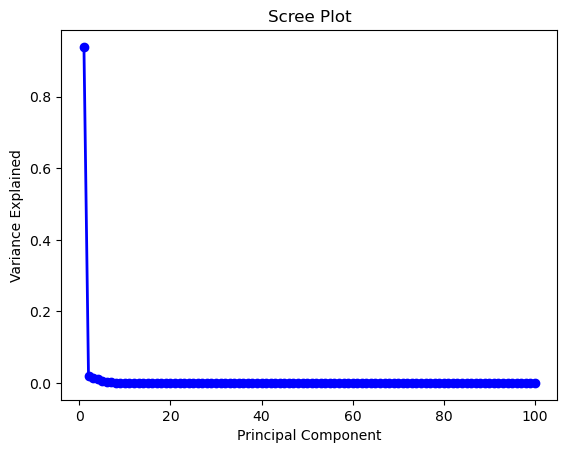

In [3]:
from Funcs.PCAExplainedVarienceRatio import PlotScree

ExplainedVarienceRatio = PlotScree(TE)

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

tTE = TE.transpose()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(tTE)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1',
                                      'principal component 2'],
                           index=tTE.index.values.tolist())
print(principalDf.head())

       principal component 1  principal component 2
U0001         -148613.226545            4871.878072
U0002         -164066.498426            7264.662067
U0006          -60044.415263            1120.313528
U0007          -69429.025089           -7198.240268
U0010         -108370.280202            8090.710344


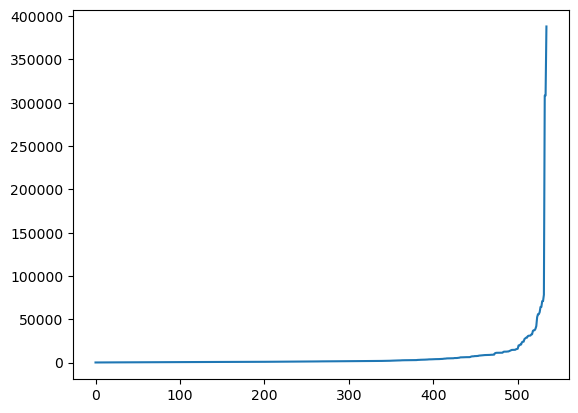

In [5]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(principalDf)
distances, indices = nbrs.kneighbors(principalDf)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

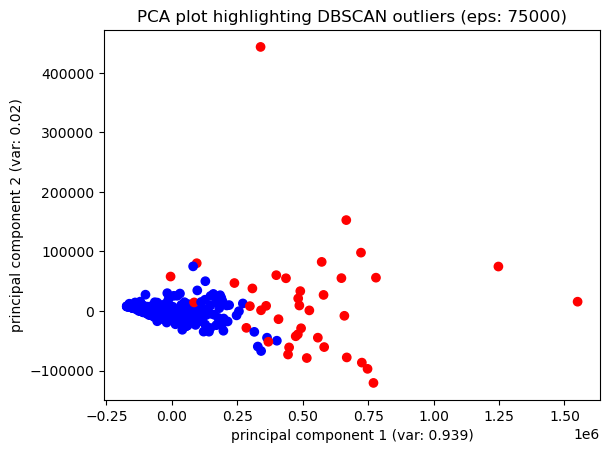

In [8]:
from sklearn.cluster import DBSCAN
epsilon = 75000
dbscan = DBSCAN(eps = epsilon, min_samples = 5)
tTEoutlier = dbscan.fit(tTE)
clusters = tTEoutlier.labels_

outlier = []
colors = []

for cluster in clusters:
    if cluster < 0:
        colors.append('r')
        outlier.append(1)
    else:
        colors.append('b')
        outlier.append(0)

tTE.loc[:, 'outlier'] = outlier

plt.scatter(principalDf.loc[:,'principal component 1'],
            principalDf.loc[:, 'principal component 2'],
            c=colors)
plt.title(f'PCA plot highlighting DBSCAN outliers (eps: {round(epsilon, 3)})')
plt.xlabel(f'principal component 1 (var: {round(ExplainedVarienceRatio[0], 3)})')
plt.ylabel(f'principal component 2 (var: {round(ExplainedVarienceRatio[1], 3)})')
plt.savefig('PCA-DBSCAN-Outliers.png')
plt.show()

In [13]:
outlier = tTE.loc[:, 'outlier']
outlier.loc[~(outlier==0)]
#tTE.loc[:, 'outlier'].to_csv('UROMOL-Outliers.csv')

U0013    1
U0183    1
U0200    1
U0204    1
U0262    1
U0434    1
U0516    1
U0556    1
U0965    1
U1232    1
U1240    1
U1242    1
U1248    1
U2026    1
U2027    1
U2031    1
U2032    1
U2033    1
U2035    1
U2038    1
U2041    1
U2042    1
U2045    1
U2048    1
U2051    1
U2053    1
U2056    1
U2058    1
U2060    1
U2062    1
U2065    1
U2070    1
U2071    1
U2077    1
U2078    1
U2091    1
U2092    1
U2094    1
U2099    1
U2115    1
Name: outlier, dtype: int64